#Library Imports

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Dataset Imports - from Google drive

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
raw_data_path = r'/content/gdrive/MyDrive/Datasets/data_assignment.csv'

In [4]:
raw_data = pd.read_csv(raw_data_path)
raw_data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Exploratory Data Analysis

## Defining EDA function

In [5]:
def get_metadata(dataframe):
    '''Gets all the Metadata Information about the Dataframe'''
    print("\nBASIC INFORMATION\n")
    print(dataframe.info())
    print("=" * 150)
    print("STATISTICAL INFORMATION\n")
    display(dataframe.describe(include='all').T)
    print("=" * 150)
    print("Dataframe Shape\n", dataframe.shape)
    print("=" * 150)
    print("Number of Duplicate Rows\n", dataframe.duplicated().sum())
    print("=" * 150)
    print("NULL Values Check")
    for col in dataframe.columns:
        print(col, dataframe[col].isnull().sum())
    print("=" * 150)
    print("UNIQUE VALUES IN EVERY COLUMN")
    for col in dataframe.columns:
        print(col)
        print(dataframe[col].unique())
        print('-' * 150)
    categorical_cols = [var for var in dataframe.columns if dataframe[var].dtype=='O']
    numerical_cols = [var for var in dataframe.columns if dataframe[var].dtype!='O']
    print("CATEGORICAL FEATURES\n", categorical_cols)
    print("=" * 150)
    print("NUMERICAL FEATURES\n", numerical_cols)
    print("=" * 150)
    print("Negative Valued Column")
    for col in numerical_cols:
        if min(dataframe[col]) < 0:
            print(col)
    print("=" * 150)
    display(dataframe.head(3))

In [6]:
get_metadata(raw_data)


BASIC INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None
STATISTICAL INFORMAT

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Item_Identifier,8523,1559,FDW13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Weight,7060.0,NaN,NaN,NaN,12.857645,4.643456,4.555,8.77375,12.6,16.85,21.35
Item_Fat_Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Visibility,8523.0,NaN,NaN,NaN,0.066132,0.051598,0.0,0.026989,0.053931,0.094585,0.328391
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_MRP,8523.0,NaN,NaN,NaN,140.992782,62.275067,31.29,93.8265,143.0128,185.6437,266.8884
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Establishment_Year,8523.0,NaN,NaN,NaN,1997.831867,8.37176,1985.0,1987.0,1999.0,2004.0,2009.0
Outlet_Size,6113,3,Medium,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dataframe Shape
 (8523, 12)
Number of Duplicate Rows
 0
NULL Values Check
Item_Identifier 0
Item_Weight 1463
Item_Fat_Content 0
Item_Visibility 0
Item_Type 0
Item_MRP 0
Outlet_Identifier 0
Outlet_Establishment_Year 0
Outlet_Size 2410
Outlet_Location_Type 0
Outlet_Type 0
Item_Outlet_Sales 0
UNIQUE VALUES IN EVERY COLUMN
Item_Identifier
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
------------------------------------------------------------------------------------------------------------------------------------------------------
Item_Weight
[ 9.3    5.92  17.5   19.2    8.93  10.395 13.65     nan 16.2   11.8
 18.5   15.1   17.6   16.35   9.    13.35  18.85  14.6   13.85  13.
  7.645 11.65   5.925 19.25  18.6   18.7   17.85  10.     8.85   9.8
 13.6   21.35  12.15   6.42  19.6   15.85   7.39  10.195  9.895 10.895
  7.905  9.195  8.365  7.97  17.7   19.35   8.645 15.6   18.25   7.855
  7.825  8.39  12.85  19.     5.905  7.76  16.75  15.5    6.055  6.305
 20.85  20.75   8.895 19.7 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


Inference:

*  8523 rows, 12 columns
*   4 Float Columns, 1 Integer Column, 7 String Columns  
*   From the statistical summary, we can infer that the Item_Visibility and Item_Outlet_Sales columns have outliers(more can be analysed using BoxPlot)
    * Item_Visibility
      *  min(0th percentile) - 0.0 ==> Visibility cannot be 0 so, needs pre-processing
      *  25th percentile - 0.026989
      *  50th percentile - 0.053931
      *  75th percentile - 0.094585
      *  max(100th percentile) - 0.328391[differs much from the 75th percentile]
    * Item_Outlet_Sales
      *  min(0th percentile) - 33.29
      *  25th percentile - 834.2474
      *  50th percentile - 1794.331
      *  75th percentile - 3101.2964
      *  max(100th percentile) - 13086.9648[differs much from the 75th percentile]
*  Item_Weight and Outlet_Size columns has NULL values
*  Item_Fat_Content has error values - ['Low Fat', 'Regular', 'low fat', 'LF', 'reg'] - Low Fat and Regular are the only 2 categories
* Outlet_Establishment_Year has larger values as it corresponds to 'Year'. So, we could create a new column as 'Outlet_Age'



# Pre-Processing

## Transforming Typo Errors

In [7]:
raw_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [8]:
fat_content = raw_data.replace({'Item_Fat_Content' : {'LF' : 'Low Fat', 'low fat' : 'Low Fat', 'reg' : 'Regular'}})
fat_content.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [9]:
fat_content['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

## Imputing NULL values

### Item_Weight

In [10]:
fat_content['Item_Weight'].isnull().sum()

1463

In [11]:
fillna_itemwt = fat_content.copy()
fillna_itemwt.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [12]:
fillna_itemwt['Item_Weight'] = fat_content['Item_Weight'].fillna(fat_content.groupby(['Item_Fat_Content', 'Item_Type'])['Item_Weight'].transform('mean'))
fillna_itemwt.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [13]:
fillna_itemwt['Item_Weight'].isnull().sum()

0

### Outlet_Type

Analysis before Imputing

In [14]:
high = fillna_itemwt[fillna_itemwt['Outlet_Size']=='High'][['Outlet_Location_Type', 'Outlet_Type']]
print("Outlet_Type=High:\n", high[['Outlet_Location_Type', 'Outlet_Type']].drop_duplicates())

medium = fillna_itemwt[fillna_itemwt['Outlet_Size']=='Medium'][['Outlet_Location_Type', 'Outlet_Type']]
print("\nOutlet_Type=Medium:\n", medium[['Outlet_Location_Type', 'Outlet_Type']].drop_duplicates())

small = fillna_itemwt[fillna_itemwt['Outlet_Size']=='Small'][['Outlet_Location_Type', 'Outlet_Type']]
print("\nOutlet_Type=Small:\n", small[['Outlet_Location_Type', 'Outlet_Type']].drop_duplicates())

Outlet_Type=High:
   Outlet_Location_Type        Outlet_Type
4               Tier 3  Supermarket Type1

Outlet_Type=Medium:
   Outlet_Location_Type        Outlet_Type
0               Tier 1  Supermarket Type1
1               Tier 3  Supermarket Type2
7               Tier 3  Supermarket Type3

Outlet_Type=Small:
    Outlet_Location_Type        Outlet_Type
11               Tier 1  Supermarket Type1
19               Tier 2  Supermarket Type1
23               Tier 1      Grocery Store


In [15]:
fillna_itemwt[fillna_itemwt['Outlet_Size'].isnull()][['Outlet_Location_Type', 'Outlet_Type']].drop_duplicates()

,Outlet_Location_Type,Outlet_Type
3,Tier 3,Grocery Store
8,Tier 2,Supermarket Type1


Imputing Outlet_Type values:
1.   Medium : Outlet_Location_Type - Tier 3, Outlet_Type - Grocery Store
2.   Small : Outlet_Location_Type - Tier 2, Outlet_Type - Supermarket Type1 [This is a straight-forward imputation with the previous analysis]



In [16]:
def get_outlet_Type(row):
    if (row['Outlet_Location_Type']=='Tier 3') & (row['Outlet_Type']=='Supermarket Type1'):
        return 'High'
    if (row['Outlet_Location_Type']=='Tier 1') & (row['Outlet_Type']=='Supermarket Type1') | (row['Outlet_Location_Type']=='Tier 3') & (row['Outlet_Type']=='Supermarket Type2') | (row['Outlet_Location_Type']=='Tier 3') & (row['Outlet_Type']=='Grocery Store'):
        return 'Medium'
    elif (row['Outlet_Location_Type']=='Tier 1') & (row['Outlet_Type']=='Supermarket Type1') | (row['Outlet_Location_Type']=='Tier 2') & (row['Outlet_Type']=='Supermarket Type1') | (row['Outlet_Location_Type']=='Tier 1') & (row['Outlet_Type']=='Grocery Store'):
        return 'Small'
    else:
        return 'Medium'

In [17]:
imp_outlet_type = fillna_itemwt.copy()
imp_outlet_type['Outlet_Size'] = fillna_itemwt.apply(get_outlet_Type, axis=1)
imp_outlet_type.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [18]:
imp_outlet_type['Outlet_Size'].isnull().sum()

0

In [19]:
fillna_itemwt['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [20]:
imp_outlet_type['Outlet_Size'].value_counts()

Medium    4278
Small     3313
High       932
Name: Outlet_Size, dtype: int64

In [21]:
imp_outlet_type['Outlet_Size'].isnull().sum()

0

## Imputing Error Values Item_Visibility

In [22]:
print("No. of rows where Item_Visibility=0 :", len(imp_outlet_type[imp_outlet_type['Item_Visibility']==0].index))

No. of rows where Item_Visibility=0 : 526


In [23]:
def replace_error_values(group):
  '''Filter the rows with Item_Visibility==0 and replace with group Average'''
  mask = group==0
  group[mask] = group[~mask].mean()
  return group

In [24]:
error_visib = imp_outlet_type.copy()
error_visib_groupby = error_visib.groupby(['Outlet_Size', 'Item_Type'])
error_visib['Item_Visibility'] = error_visib['Item_Visibility'].transform(replace_error_values)
error_visib.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [25]:
print("No. of rows where Item_Visibility=0 :", len(error_visib[error_visib['Item_Visibility']==0].index))

No. of rows where Item_Visibility=0 : 0


## Creating Oultet_Age out of Outlet_Establishment_Year

In [26]:
outlet_age = error_visib.copy()
outlet_age.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [27]:
from datetime import date

outlet_age['Outlet_Age'] = date.today().year - outlet_age['Outlet_Establishment_Year']
outlet_age.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,24
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,14


In [28]:
outlet_age.drop('Outlet_Establishment_Year', axis=1, inplace=True)
outlet_age.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,24
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,14


# Oulier Detection

In [29]:
data = outlet_age.copy()

## Item_Visibility

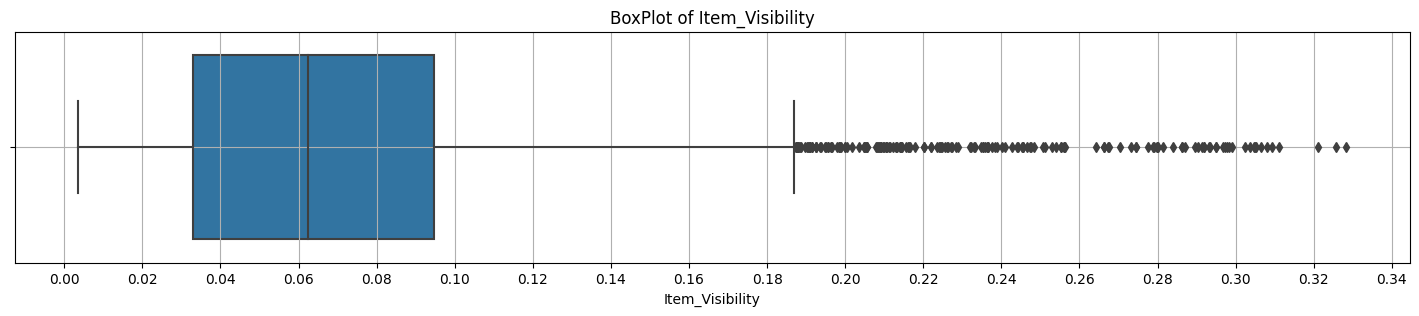

In [30]:
plt.figure(figsize=(18,3))
plt.title('BoxPlot of Item_Visibility')
sns.boxplot(x = data['Item_Visibility'])
plt.grid()
plt.xticks(np.arange(0, 0.35, step=0.02))
plt.show()

## Item_Outlet_Sales

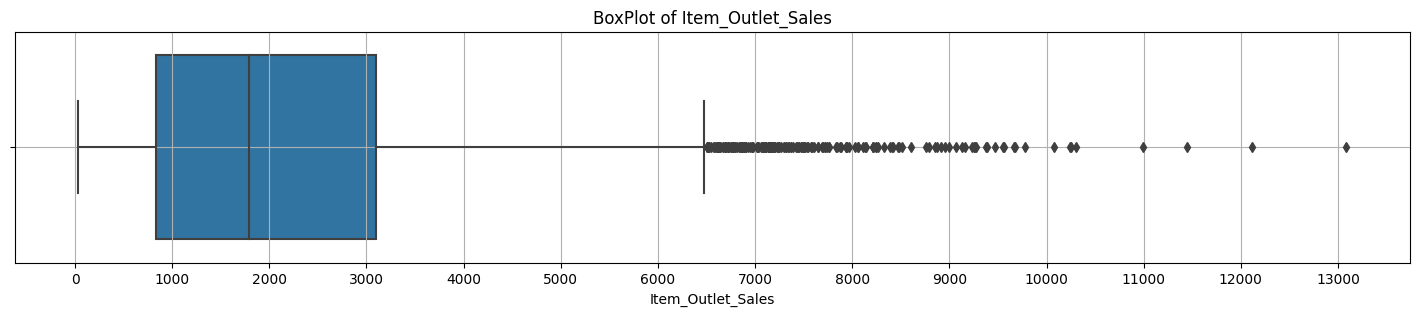

In [31]:
plt.figure(figsize=(18,3))
plt.title('BoxPlot of Item_Outlet_Sales')
sns.boxplot(x = data['Item_Outlet_Sales'])
plt.grid()
plt.xticks(np.arange(0, 13500, step=1000))
plt.show()

# Encoding Categorical Variables

In [37]:
outlet_age.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,24
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,14
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,24


## Item_Fat_Content

In [41]:
data = outlet_age.copy()
data['Item_Fat_Content'] = LabelEncoder().fit_transform(data['Item_Fat_Content'])
data['Item_Fat_Content'].unique()

array([0, 1])

## Outlet_Size

In [47]:
outlet_age['Outlet_Size'].value_counts()

Medium    4278
Small     3313
High       932
Name: Outlet_Size, dtype: int64

In [46]:
data = data.replace({'Outlet_Size':{'Small':1, 'Medium':2, 'High':3}})
data['Outlet_Size'].value_counts()

2    4278
1    3313
3     932
Name: Outlet_Size, dtype: int64

In [48]:
data.head(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,2,Tier 1,Supermarket Type1,3735.1380,24
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2,Tier 3,Supermarket Type2,443.4228,14
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,2,Tier 1,Supermarket Type1,2097.2700,24
3,FDX07,19.20,1,0.070482,Fruits and Vegetables,182.0950,OUT010,2,Tier 3,Grocery Store,732.3800,25


## Drop Item_Identifier Column

In [49]:
del data['Item_Identifier']

In [50]:
data.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,9.30,0,0.016047,Dairy,249.8092,OUT049,2,Tier 1,Supermarket Type1,3735.1380,24
1,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2,Tier 3,Supermarket Type2,443.4228,14
2,17.50,0,0.016760,Meat,141.6180,OUT049,2,Tier 1,Supermarket Type1,2097.2700,24


## One-hot Encoding

In [53]:
data_encoded = pd.get_dummies(data, columns = ['Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', "Outlet_Type"], drop_first=True)
data_encoded.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,249.8092,2,3735.1380,24,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,5.92,1,0.019278,48.2692,2,443.4228,14,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,17.50,0,0.016760,141.6180,2,2097.2700,24,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Correlation between Encoded Data

In [55]:
data_encoded.corr()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
Item_Weight,1.000000,-0.025749,-0.016839,0.026173,0.016012,0.012523,0.009386,-0.061843,-0.002123,-0.037271,...,0.000392,-0.002590,-0.017392,0.000503,0.004686,-0.015138,0.010250,-0.003636,0.001042,0.000392
Item_Fat_Content,-0.025749,1.000000,0.049915,0.006063,0.002941,0.018719,-0.003151,0.032643,0.065711,0.073235,...,0.000183,-0.003154,-0.006029,0.003147,0.004722,-0.003272,0.000241,0.000533,0.002129,0.000183
Item_Visibility,-0.016839,0.049915,1.000000,-0.005515,-0.049851,-0.134035,0.078316,0.001955,0.040276,0.007255,...,-0.052907,-0.036817,-0.040247,-0.038744,-0.040649,-0.073876,0.012391,-0.153517,-0.032501,-0.052907
Item_MRP,0.026173,0.006063,-0.005515,1.000000,0.001612,0.567574,-0.005020,-0.000112,0.001460,-0.005666,...,-0.006714,0.011969,-0.000239,0.005983,-0.003906,0.001951,-0.000744,0.004885,0.003850,-0.006714
Outlet_Size,0.016012,0.002941,-0.049851,0.001612,1.000000,0.072601,0.463197,-0.005226,0.002775,-0.009347,...,0.151312,-0.389150,-0.388915,0.150857,0.150857,-0.774665,0.692334,-0.112297,0.150675,0.151312
Item_Outlet_Sales,0.012523,0.018719,-0.134035,0.567574,0.072601,1.000000,0.049135,0.002332,-0.004656,0.007387,...,0.311192,0.052823,0.002274,0.019803,0.034264,0.058261,0.046376,0.108765,-0.038059,0.311192
Outlet_Age,0.009386,-0.003151,0.078316,-0.005020,0.463197,0.049135,1.000000,0.003631,0.006768,-0.010998,...,0.538072,-0.257868,-0.174150,0.034777,-0.048836,-0.540820,0.333895,-0.245070,-0.466336,0.538072
Item_Type_Breads,-0.061843,0.032643,0.001955,-0.000112,-0.005226,0.002332,0.003631,1.000000,-0.019918,-0.050010,...,0.007693,0.003588,0.012563,-0.003090,-0.005316,0.002933,0.001909,-0.006189,-0.000734,0.007693
Item_Type_Breakfast,-0.002123,0.065711,0.040276,0.001460,0.002775,-0.004656,0.006768,-0.019918,1.000000,-0.032828,...,-0.003550,-0.006677,-0.006638,-0.006677,0.003325,-0.008741,0.003754,-0.008695,0.000077,-0.003550
Item_Type_Canned,-0.037271,0.073235,0.007255,-0.005666,-0.009347,0.007387,-0.010998,-0.050010,-0.032828,1.000000,...,0.001136,0.011611,0.004627,0.001679,-0.005415,0.009366,-0.004612,0.001236,0.010418,0.001136


## Multi-collinearity

In [59]:
vif = pd.DataFrame()
vif['features'] = data_encoded.columns
vif['Variance_Inflation_Factor'] = [variance_inflation_factor(data_encoded.values, i) for i in range(len(data_encoded.columns))]
vif

,features,Variance_Inflation_Factor
0,Item_Weight,1.020477
1,Item_Fat_Content,1.217191
2,Item_Visibility,1.112354
3,Item_MRP,1.752824
4,Outlet_Size,inf
5,Item_Outlet_Sales,2.292137
6,Outlet_Age,inf
7,Item_Type_Breads,1.350566
8,Item_Type_Breakfast,1.158013
9,Item_Type_Canned,1.853347


### Removing Multicollinear columns

In [66]:
data_wo_otid = data_encoded.drop(columns=['Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049'])
data_wo_otid.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,249.8092,2,3735.1380,24,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5.92,1,0.019278,48.2692,2,443.4228,14,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,17.50,0,0.016760,141.6180,2,2097.2700,24,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [68]:
vif1 = pd.DataFrame()
vif1['features'] = data_wo_otid.columns
vif1['Variance_Inflation_Factor'] = [variance_inflation_factor(data_wo_otid.values, i) for i in range(len(data_wo_otid.columns))]
vif1

,features,Variance_Inflation_Factor
0,Item_Weight,1.020343
1,Item_Fat_Content,1.217157
2,Item_Visibility,1.112212
3,Item_MRP,1.750828
4,Outlet_Size,354.813457
5,Item_Outlet_Sales,2.286516
6,Outlet_Age,4.896481
7,Item_Type_Breads,1.350233
8,Item_Type_Breakfast,1.157878
9,Item_Type_Canned,1.853170


In [71]:
data_wo_otidsize_sprmkt1 = data_wo_otid.drop(columns=['Outlet_Size', 'Outlet_Type_Supermarket Type1'])
data_wo_otidsize_sprmkt1.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,249.8092,3735.1380,24,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5.92,1,0.019278,48.2692,443.4228,14,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,17.50,0,0.016760,141.6180,2097.2700,24,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [72]:
vif2 = pd.DataFrame()
vif2['features'] = data_wo_otidsize_sprmkt1.columns
vif2['Variance_Inflation_Factor'] = [variance_inflation_factor(data_wo_otidsize_sprmkt1.values, i) for i in range(len(data_wo_otidsize_sprmkt1.columns))]
vif2

,features,Variance_Inflation_Factor
0,Item_Weight,9.348735
1,Item_Fat_Content,1.846949
2,Item_Visibility,3.178942
3,Item_MRP,9.686733
4,Item_Outlet_Sales,4.858161
5,Outlet_Age,18.524118
6,Item_Type_Breads,1.328988
7,Item_Type_Breakfast,1.153062
8,Item_Type_Canned,1.859513
9,Item_Type_Dairy,1.940122


In [73]:
data_multicollinearity_removed = data_wo_otidsize_sprmkt1.copy()

# Linear Regression

In [76]:
X = data_encoded.drop(columns=['Item_Outlet_Sales'])
y = data_encoded['Item_Outlet_Sales']

## Train-Test split

In [77]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state = 8)

In [78]:
train_X.shape, test_X.shape

((5966, 35), (2557, 35))

In [79]:
train_X.head(5)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
5802,8.195,0,0.031398,91.3462,1,19,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
32,18.700,0,0.070482,256.6672,2,14,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5844,7.930,0,0.071538,44.5086,1,16,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
7720,12.850,0,0.168313,45.9060,3,36,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3488,9.300,0,0.291827,107.1964,2,25,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Modelling

In [80]:
lin_reg = LinearRegression()

In [82]:
lin_reg.fit(train_X, train_y)

LinearRegression()

In [83]:
lin_reg.intercept_, lin_reg.coef_

(-2591.5762266803317,
 array([ 3.36240728e+00,  4.92693112e+01,  1.76457722e+02,  1.53334462e+01,
         2.49210938e+02,  2.50414103e+01,  1.20366881e+02,  1.50551513e+01,
         5.65263075e+01,  3.39210564e-01, -3.05843370e+01,  5.26005060e+01,
         9.63081335e+00,  8.29789137e+01,  1.70261295e+01,  3.34368598e+01,
         2.26237689e+01,  3.27579830e+02,  1.84018200e+01,  1.59879846e+01,
         8.31869548e+01,  2.11943978e+02,  2.50613941e+02,  9.66135344e+02,
        -5.49819390e+02,  1.50398404e+03,  2.80192229e+02, -1.82537398e+01,
         1.44195903e+02,  3.63526016e+02,  5.12552430e+02, -4.70454959e+02,
         1.23221833e+03,  9.66135344e+02,  1.50398404e+03]))

In [116]:
train_predict = lin_reg.predict(train_X)
train_predict

array([1592.13179999, 3748.54973639,  858.41847834, ..., 2628.16393623,
       1596.29431874, 2012.11057736])

In [117]:
actual_vs_predicted = pd.DataFrame()
actual_vs_predicted['Actual'] = train_y
actual_vs_predicted['Predicted'] = train_predict
actual_vs_predicted = actual_vs_predicted.reset_index().drop(columns=['index']).reset_index().iloc[:200]
actual_vs_predicted.head(5)

,index,Actual,Predicted
0,0,1388.1930,1592.131800
1,1,3068.0064,3748.549736
2,2,1249.0408,858.418478
3,3,885.5140,777.474556
4,4,420.7856,-192.716548


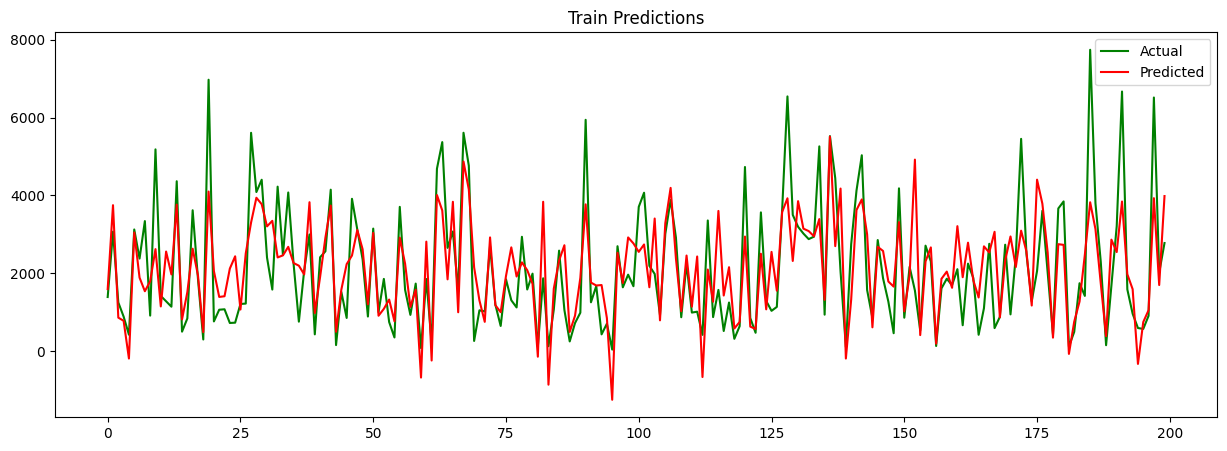

In [118]:
plt.figure(figsize=(15,5))
plt.plot(actual_vs_predicted['index'], actual_vs_predicted['Actual'], color='green')
plt.plot(actual_vs_predicted['index'], actual_vs_predicted['Predicted'], color='red')
plt.title('Train Predictions')
plt.legend(['Actual', 'Predicted'])

In [111]:
test_predict = lin_reg.predict(test_X)
test_predict

array([3949.37457829, 2638.82210987, 4062.88654306, ..., 2388.06632012,
       4482.61119685, 3079.75715995])

In [112]:
tst_actual_vs_predicted = pd.DataFrame()
tst_actual_vs_predicted['Actual'] = test_y
tst_actual_vs_predicted['Predicted'] = lin_reg.predict(test_X)
tst_actual_vs_predicted = tst_actual_vs_predicted.reset_index().drop(columns=['index']).reset_index().iloc[:200]
tst_actual_vs_predicted.head(5)

,index,Actual,Predicted
0,0,3615.2940,3949.374578
1,1,3115.9440,2638.822110
2,2,2536.6980,4062.886543
3,3,1431.4700,892.534308
4,4,1976.0944,2450.681537


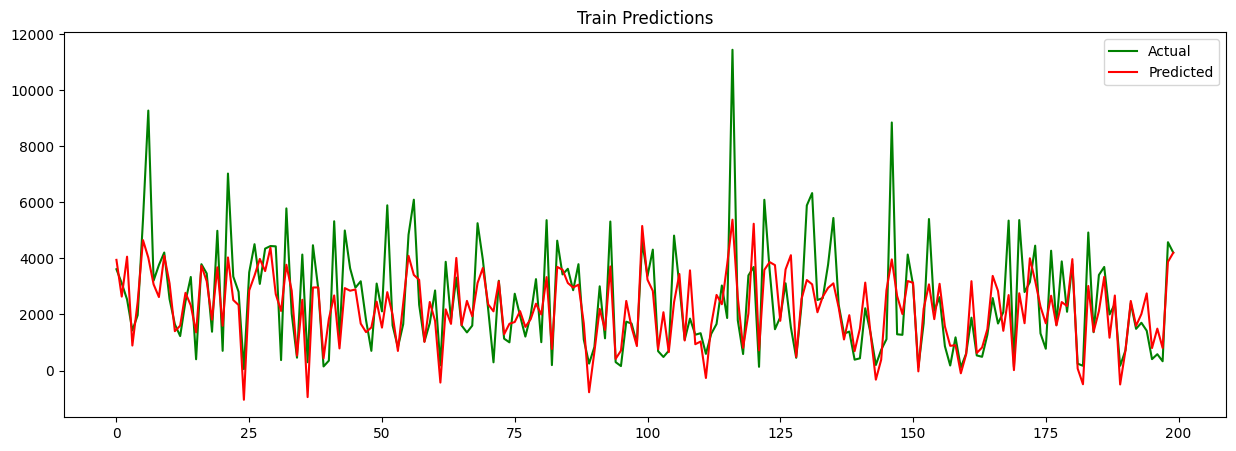

In [115]:
plt.figure(figsize=(15,5))
plt.plot(tst_actual_vs_predicted['index'], tst_actual_vs_predicted['Actual'], color='green')
plt.plot(tst_actual_vs_predicted['index'], tst_actual_vs_predicted['Predicted'], color='red')
plt.title('Test Predictions')
plt.legend(['Actual', 'Predicted'])

# Defining Modelling Function

In [142]:
def split_data(df, target_col, test_size=0.3, random_state=8):
  X = df.drop(columns=[target_col])
  y = df[target_col]
  return train_test_split(X, y, test_size=test_size, random_state = random_state)

def scale_data(data, train_X, test_X):
  scale = StandardScaler()
  scale.fit(train_X)
  train_X_scaled = pd.DataFrame(scale.transform(train_X), columns=train_X.columns)
  test_X_scaled = pd.DataFrame(scale.transform(test_X), columns=test_X.columns)
  return train_X_scaled, test_X_scaled

def evaluation_metrics(actual,pred):
  mse = mean_squared_error(actual,pred)
  rmse = np.sqrt(mean_squared_error(actual,pred))
  mae = mean_absolute_error(actual,pred)
  mape = mean_absolute_percentage_error(actual,pred)
  r2 = r2_score(actual,pred)
  print("MSE:", mse)
  print("RMSE:", rmse)
  print("MAE:", mae)
  print("MAPE:", mape)
  print("R2 Score:", r2)

def get_actual_vs_predicted_df(data_y, data_predict):
  actual_vs_predicted = pd.DataFrame()
  actual_vs_predicted['Actual'] = data_y
  actual_vs_predicted['Predicted'] = data_predict
  return actual_vs_predicted.reset_index().drop(columns=['index']).reset_index().iloc[:200]

def plot_actual_vs_predicted(data_y, data_predict, train_or_test='train'):
  actual_vs_predicted = get_actual_vs_predicted_df(data_y, data_predict)
  plt.figure(figsize=(15,5))
  plt.plot(actual_vs_predicted['index'], actual_vs_predicted['Actual'], color='green')
  plt.plot(actual_vs_predicted['index'], actual_vs_predicted['Predicted'], color='red')
  plt.title(f'{train_or_test.upper()} Predictions')
  plt.legend(['Actual', 'Predicted'])

def apply_linear_regression(data, target_col, scaling=False):
  print('Target Column :', target_col)
  print('Splitting the data to train and test...')
  train_X, test_X, train_y, test_y = split_data(data, target_col, test_size=0.3, random_state=8)
  print('train_X shape:', train_X.shape)
  print('test_X shape:', test_X.shape)

  if scaling is True:
    print('\nScaling is set to True')
    train_X, test_X = scale_data(data, train_X, test_X)
  lin_reg = LinearRegression()
  lin_reg.fit(train_X, train_y)
  print('\nIntercept:', lin_reg.intercept_)
  print('Coefficient:', lin_reg.coef_)

  print("\nTRAIN PREDICTIONS")
  print('='*len('TRAIN PREDICTIONS'))
  train_predict = lin_reg.predict(train_X)
  print('Evaluation Metrics:')
  print('-'*len('Evaluation Metrics:'))
  evaluation_metrics(train_y,train_predict)
  plot_actual_vs_predicted(train_y, train_predict, train_or_test='train')

  print("\nTEST PREDICTIONS")
  print('='*len('TEST PREDICTIONS'))
  test_predict = lin_reg.predict(test_X)
  print('Evaluation Metrics:')
  print('-'*len('Evaluation Metrics:'))
  evaluation_metrics(test_y,test_predict)
  plot_actual_vs_predicted(test_y, test_predict, train_or_test='test')

## Model with Encoded Data

Target Column : Item_Outlet_Sales
Splitting the data to train and test...
train_X shape: (5966, 35)
test_X shape: (2557, 35)

Intercept: -2591.5762266803317
Coefficient: [ 3.36240728e+00  4.92693112e+01  1.76457722e+02  1.53334462e+01
  2.49210938e+02  2.50414103e+01  1.20366881e+02  1.50551513e+01
  5.65263075e+01  3.39210564e-01 -3.05843370e+01  5.26005060e+01
  9.63081335e+00  8.29789137e+01  1.70261295e+01  3.34368598e+01
  2.26237689e+01  3.27579830e+02  1.84018200e+01  1.59879846e+01
  8.31869548e+01  2.11943978e+02  2.50613941e+02  9.66135344e+02
 -5.49819390e+02  1.50398404e+03  2.80192229e+02 -1.82537398e+01
  1.44195903e+02  3.63526016e+02  5.12552430e+02 -4.70454959e+02
  1.23221833e+03  9.66135344e+02  1.50398404e+03]

TRAIN PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1234916.259661923
RMSE: 1111.2678613466346
MAE: 822.2803355090693
MAPE: 1.007457919992392
R2 Score: 0.5604891326164327

TEST PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1361961.976959

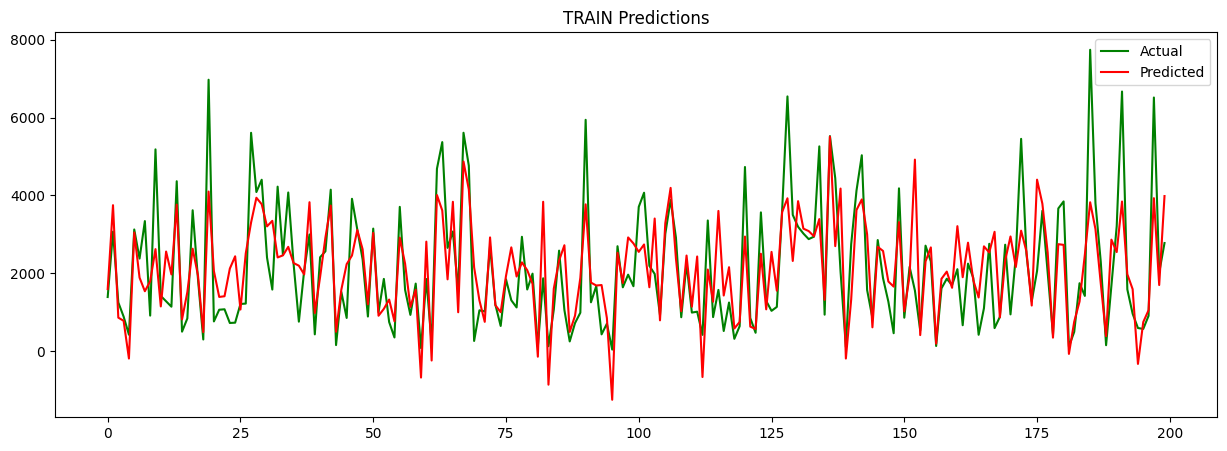

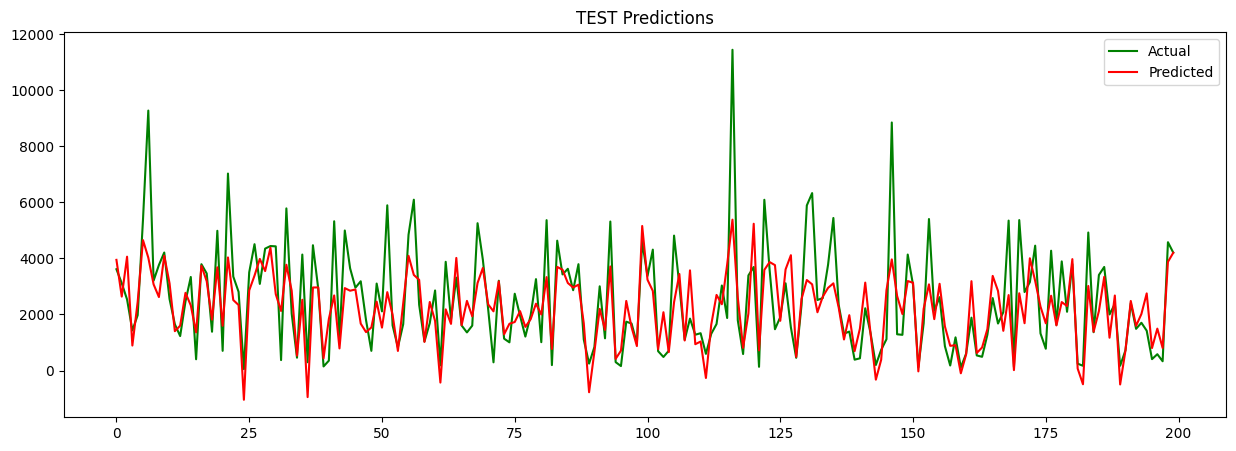

In [143]:
apply_linear_regression(data=data_encoded, target_col='Item_Outlet_Sales')

## Model with Multicollinearity removed

Target Column : Item_Outlet_Sales
Splitting the data to train and test...
train_X shape: (5966, 24)
test_X shape: (2557, 24)

Intercept: 471.2383598904687
Coefficient: [ 2.94220652e+00  5.79636308e+01 -3.03077678e+03  1.52684165e+01
 -2.14847351e+01  5.93400719e+01 -5.92158108e+01  5.48723132e+01
  4.24845193e-02 -2.48934121e+01  5.29581038e+01  3.72245783e+01
  3.27622595e+01  1.38805580e-01 -4.73556500e+01 -7.91914849e+01
  2.63337209e+02  1.85602703e+01  1.13982917e+01  1.64539905e+02
  2.02833735e+02 -1.99060234e+02 -1.42872716e+01  2.16859105e+03]

TRAIN PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1537329.3943029593
RMSE: 1239.8908799983003
MAE: 934.6360690980523
MAPE: 1.0745902930813325
R2 Score: 0.45285927668543025

TEST PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1667184.4567949409
RMSE: 1291.1949724170013
MAE: 968.4238326301456
MAPE: 1.1562583425530912
R2 Score: 0.47038860222277457


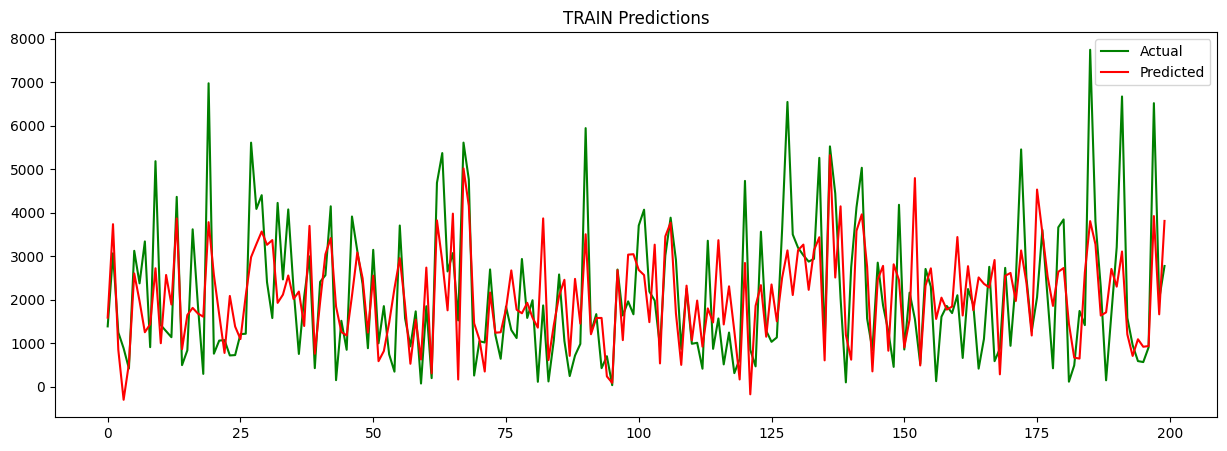

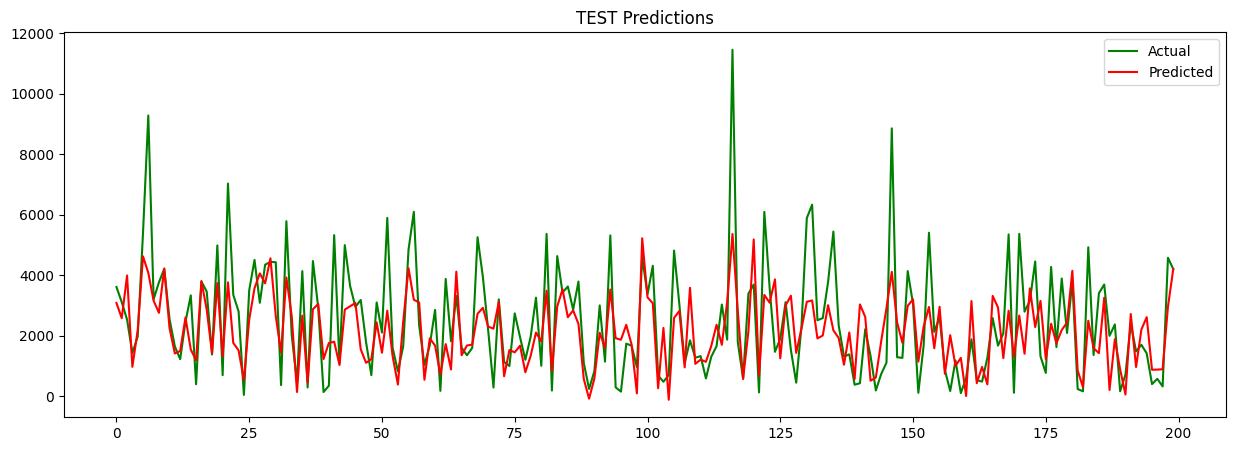

In [144]:
apply_linear_regression(data=data_multicollinearity_removed, target_col='Item_Outlet_Sales')

## Model without OutletID

Target Column : Item_Outlet_Sales
Splitting the data to train and test...
train_X shape: (5966, 26)
test_X shape: (2557, 26)

Intercept: -2350.065122442002
Coefficient: [ 3.53923190e+00  4.71934167e+01  1.96332988e+02  1.53349409e+01
  4.96989325e+02 -3.29240528e+00  1.23930601e+02  1.78081535e+01
  5.46192575e+01 -1.32939455e+00 -2.77844500e+01  5.42185547e+01
  8.96171654e+00  8.37574512e+01  1.71918149e+01  3.71496779e+01
  1.65235569e+01  3.26853949e+02  1.94379599e+01  1.20152378e+01
  9.11396221e+01  4.90778556e+02 -4.73793243e+02  1.46156112e+03
  1.59158744e+03  3.34731578e+03]

TRAIN PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1239692.7150178729
RMSE: 1113.4148889869728
MAE: 822.8734899635851
MAPE: 1.0080022779104172
R2 Score: 0.5587891760241638

TEST PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1359689.7572419909
RMSE: 1166.0573558972092
MAE: 860.8386346526698
MAPE: 1.0834471122011118
R2 Score: 0.5680698737674963


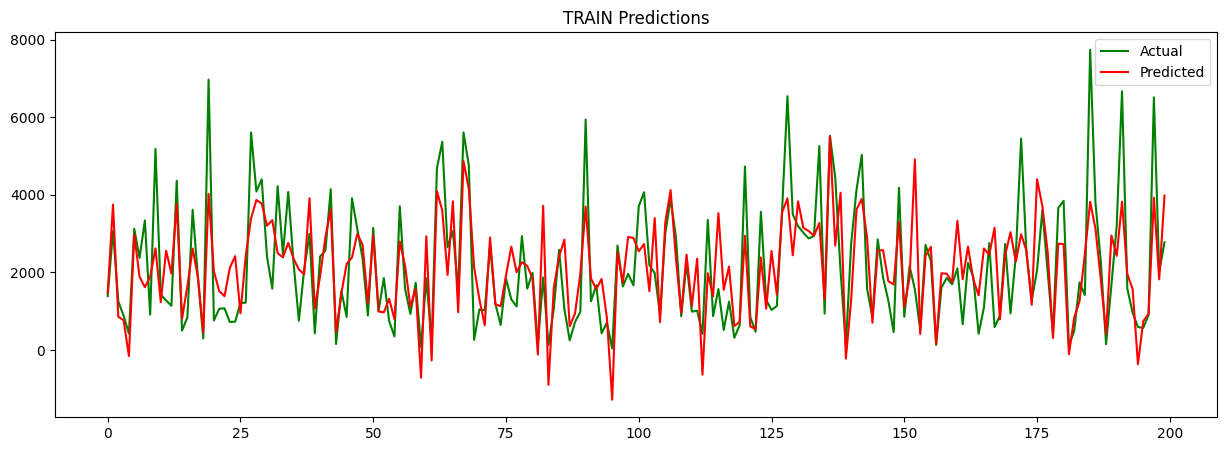

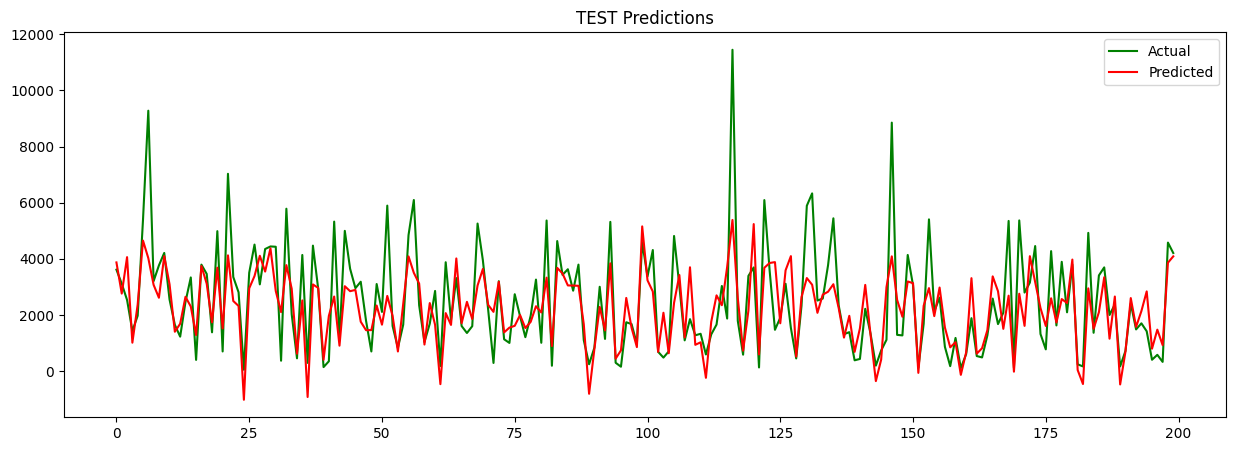

In [145]:
apply_linear_regression(data=data_wo_otid, target_col='Item_Outlet_Sales')

## Model without Item_visibility

Target Column : Item_Outlet_Sales
Splitting the data to train and test...
train_X shape: (5966, 34)
test_X shape: (2557, 34)

Intercept: -2571.549438416662
Coefficient: [ 3.32835498e+00  4.98939351e+01  1.53333027e+01  2.47844832e+02
  2.50581960e+01  1.19441621e+02  1.66389417e+01  5.59846601e+01
  1.04748949e+00 -3.13332503e+01  5.23838517e+01  9.96817842e+00
  8.04757924e+01  1.56893523e+01  3.12529853e+01  1.98531807e+01
  3.28170468e+02  1.77184335e+01  1.54960675e+01  8.35310822e+01
  2.10585403e+02  2.50187386e+02  9.62810839e+02 -5.48365715e+02
  1.50021588e+03  2.79840600e+02 -1.89217004e+01  1.43234127e+02
  3.62705086e+02  5.11106286e+02 -4.68679784e+02  1.22763090e+03
  9.62810839e+02  1.50021588e+03]

TRAIN PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1234980.9147842422
RMSE: 1111.296951666944
MAE: 822.3128787496291
MAPE: 1.0071274154666183
R2 Score: 0.5604661216400455

TEST PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1361004.5495241042
RMSE: 1166.

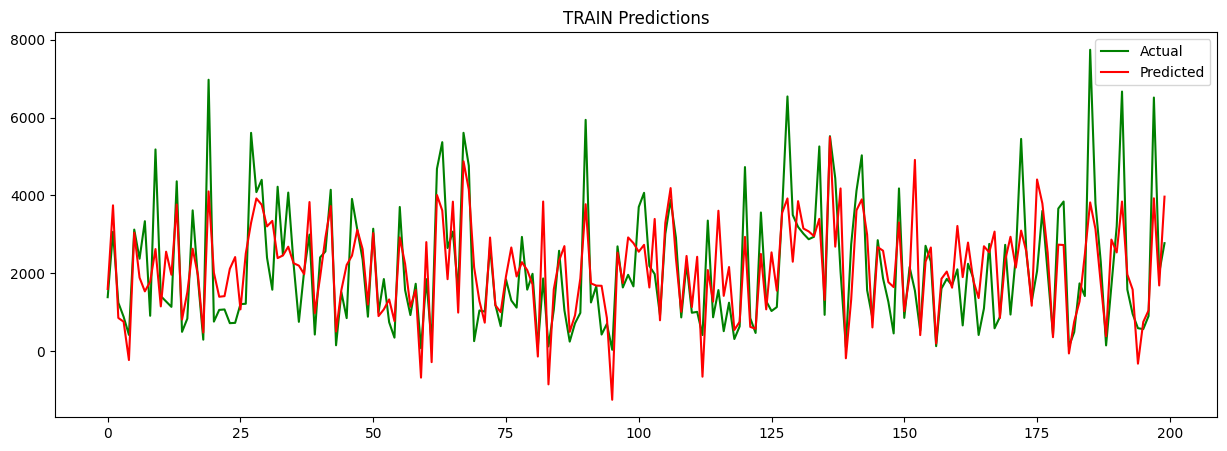

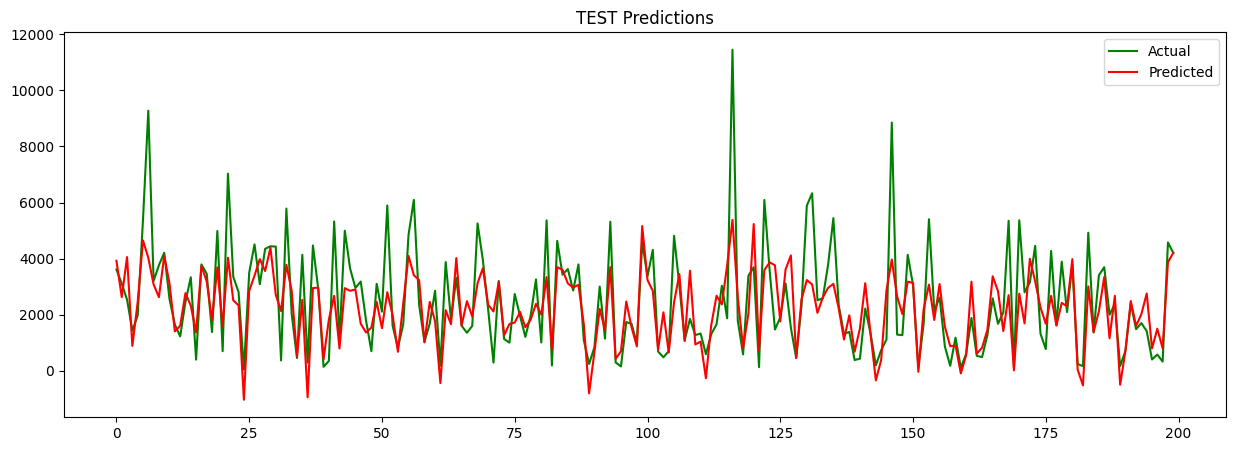

In [146]:
apply_linear_regression(data=data_encoded.drop(columns=['Item_Visibility']), target_col='Item_Outlet_Sales')

## Model without OutletID and Item_visibility

Target Column : Item_Outlet_Sales
Splitting the data to train and test...
train_X shape: (5966, 25)
test_X shape: (2557, 25)

Intercept: -2326.6647537258928
Coefficient: [ 3.50171894e+00  4.78864130e+01  1.53347700e+01  4.94553058e+02
 -3.23917534e+00  1.22901691e+02  1.95706029e+01  5.40089078e+01
 -5.45458756e-01 -2.86093958e+01  5.39786074e+01  9.33175457e+00
  8.09738342e+01  1.57029924e+01  3.47263184e+01  1.34304812e+01
  3.27509111e+02  1.86788221e+01  1.14625479e+01  9.15386367e+01
  4.88905586e+02 -4.71879637e+02  1.45533828e+03  1.58447931e+03
  3.33839101e+03]

TRAIN PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1239772.772967579
RMSE: 1113.4508399420151
MAE: 822.8850165014512
MAPE: 1.0076320609237708
R2 Score: 0.5587606831294909

TEST PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1358591.1372598659
RMSE: 1165.5861775346625
MAE: 860.6669633502623
MAPE: 1.083572573257226
R2 Score: 0.5684188703419232


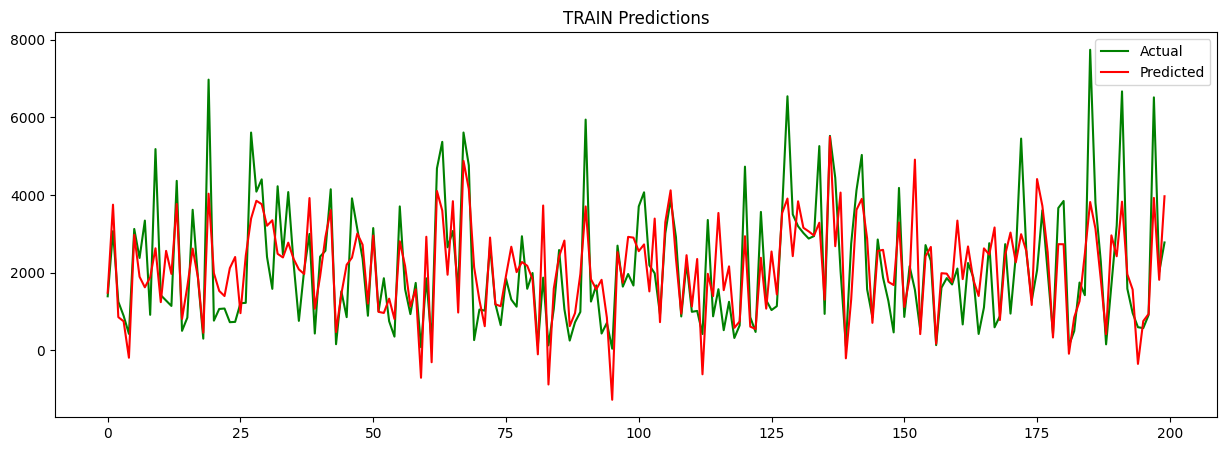

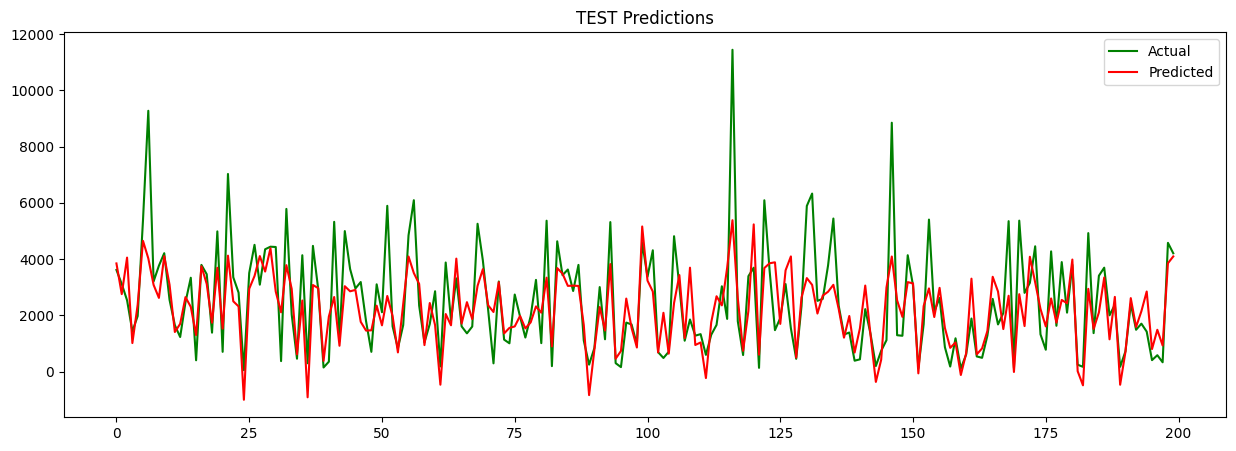

In [147]:
apply_linear_regression(data=data_wo_otid.drop(columns=['Item_Visibility']), target_col='Item_Outlet_Sales')

## Scaling

Target Column : Item_Outlet_Sales
Splitting the data to train and test...
train_X shape: (5966, 35)
test_X shape: (2557, 35)

Scaling is set to True

Intercept: 2165.5317897236623
Coefficient: [ 1.41564892e+01  2.35254554e+01  8.46729965e+00  9.57062039e+02
  1.68725574e+14  2.53451536e+14  2.02485314e+01  1.77540538e+00
  1.49793384e+01  2.38519628e-01 -9.09939801e+00  1.84371567e+01
  1.42679265e+00  2.05057930e+01  5.44331722e+00  7.32268437e+00
  2.93926921e+00  2.80460014e+01  6.43777554e+00  3.62801455e+00
  1.13799004e+01 -3.40797600e+14  5.59122703e+14  2.99065572e+13
  1.82890485e+14 -2.92663142e+13  5.24500380e+14  5.01486028e+14
  1.22826071e+14  1.40670015e+14 -3.84637670e+14  4.50066515e+14
  2.37331784e+14  7.58574818e+13 -9.36047743e+13]

TRAIN PREDICTIONS
Evaluation Metrics:
-------------------
MSE: 1234916.9732698635
RMSE: 1111.2681824248652
MAE: 822.2986141154727
MAPE: 1.007652314803532
R2 Score: 0.5604888786409568

TEST PREDICTIONS
Evaluation Metrics:
---------------

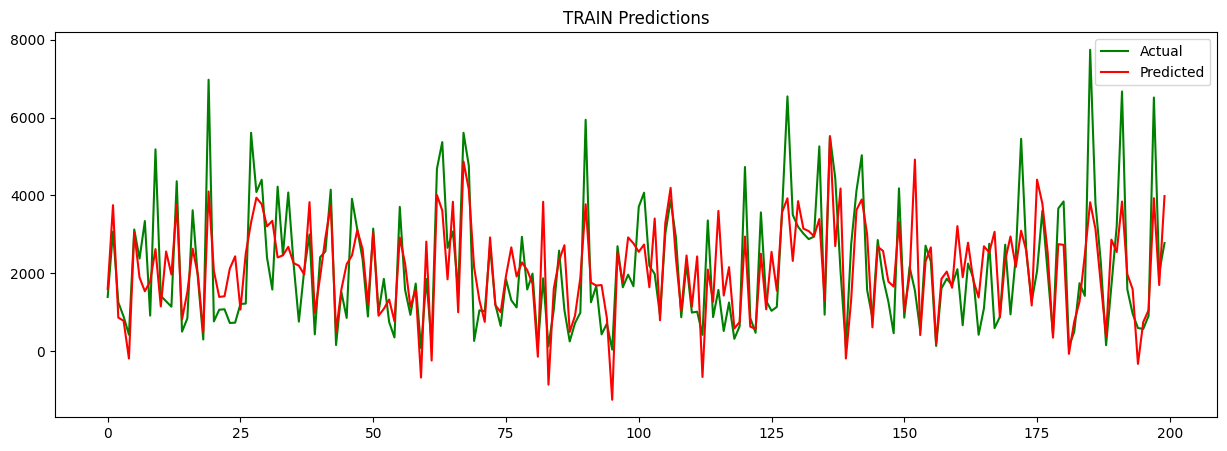

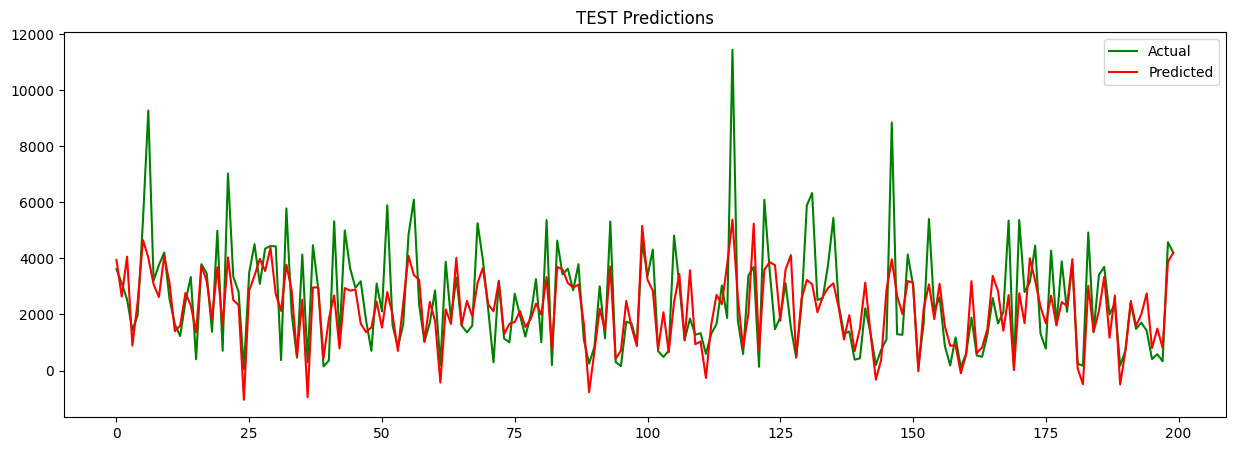

In [148]:
apply_linear_regression(data=data_encoded, target_col='Item_Outlet_Sales', scaling=True)